In [3]:
# !pip install fastai --upgrade
# !pip install transformers --upgrade
# !pip uninstall splitter

In [4]:
from fastai.basics import *
from fastai.callback.all import *
from fastai.text.all import *
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AutoConfig
from transformers import RobertaTokenizer, RobertaTokenizerFast
from splitters import *
import json

In [5]:
df=pd.read_csv("data/train_en.csv")


df=df.drop(["Column1"],axis=1)
df=df.rename({"Narrative":"text","Abteilung":"label"},axis=1)
df.head()

,text,label
0,"I'm excited about your programs and use Windows 7 on a notebook (which is a bit cumbersome because it's too small) and an iMac, which is much more comfortable because of the size. Are your programs Apple compatible? ...or are there any problems or limitations? I would appreciate a quick reply, as I am eager to use your programs.",4
1,My Super Bill administrator does not work on Windows 7 Where can I get an abgrade version ? or do I have to buy the program again ?,4
2,"Dear Sir or Madam, on 31.10.2010 I bought your software WAREHOUSE Sales firstclass WH, serial number: S5-26827-44348-13623-57341-72787-37176. Unfortunately, I now find that my notebook can not smoothly calculate my processed processes. Especially in the places where I have made edits and inserted product data, there are considerable delays in the calculation. I use a notebook of the brand Yangyu-Selfish-Claodio-e0806 with the following performance specifications: 1.Processor: Intel (R) Core (TM) 5 Duo CPU T543 @ 3.3 GHz 3.3GHz3 GByte 2.RAM: 4.0 GB 3. graphics card: NVIDIA Road Gefor...",1
3,"Before burning, the following problem occurs. Where can I adjust my burner, or do I need a new burner. But can not really be? My burner is an integrated one in the laptop. Laptop HP Compaq 2850s burner/drive GWWF corp. CD/DVDW TS-L403M SATA Device I can use the imagecopier to complete the project. Thank you very much for the answer.",2
4,"So I have recently purchased Specs Manager 9. Now my detailsheet is almost finished -24 sheets/150 MB- only a few more data are missing and then I could finally release it... But now I have a problem which I can't solve by myself: Since a few days I get always the error message ""Not enough memory"" I get at the moment not even my project completely about the program called!!! In the display via the program some data are gone and except for 5-6 sheets all others are gone too...;o( Only via the ""sheets and layers group view"" you can see that the sheets are still there at all. Even the ""Help""...",5


In [6]:
class FastHugsTokenizer():
    """    
        transformer_tokenizer : takes the tokenizer that has been loaded from the tokenizer class
        model_name : model type set by the user
        max_seq_len : override default sequence length, typically 512 for bert-like models.
                           `transformer_tokenizer.max_len_single_sentence` and `transformer_tokenizer.max_len_sentences_pair` 
                           both account for the need to add additional special tokens, i.e. for RoBERTa-base 
                           max_len_single_sentence==510, leaving space for the 2 additional special tokens 
                           to be added for the model's default 512 positional embeddings
        pair : whether a single sentence (sequence) or pair of sentences are used
        
        NOTES:
            - `init` will have to be modified to enable sequence lengths larger than the tokenizer default
            - need to add case when pretrained==False
            - Pretrained==True will cut the sequence at the max length
            - Good functions in `tokenization_utils.py`
            - tokenizer.encode_plus or tokenizer.batch_encode_plus are great, but don't play nice with fastai multiprocessiing
            - https://huggingface.co/transformers/main_classes/tokenizer.html#transformers.PreTrainedTokenizer.encode_plus
            - encoded_dict=tokenizer.encode_plus(text=o, return_tensors="pt", max_length=tokenizer.max_len, pad_to_max_length=True)
        Returns:
            - Tokenized text, up to the max sequence length set by the user or the tokenzier default
    """
    def __init__(self, transformer_tokenizer=None, model_name='roberta', max_seq_len=None, 
                 pretrained=True, pair=False, **kwargs): 
        self.model_name, self.tok, self.max_seq_len=model_name, transformer_tokenizer, max_seq_len
        if pretrained:
            if self.max_seq_len:
                if pair: assert self.max_seq_len<=self.tok.max_len_sentences_pair, 'WARNING: max_seq_len needs to be less than or equal to transformer_tokenizer.max_len_sentences_pair'
                else: assert self.max_seq_len<=self.tok.max_len_single_sentence, 'WARNING: max_seq_len needs to be less than or equal to transformer_tokenizer.max_len_single_sentence'
            else:
                if pair: self.max_seq_len=ifnone(max_seq_len, self.tok.max_len_sentences_pair) 
                else: self.max_seq_len=ifnone(max_seq_len, self.tok.max_len_single_sentence)

    def do_tokenize(self, o:str):
        """Returns tokenized text, adds prefix space if needed, limits the maximum sequence length"""
        if 'roberta' in model_name: tokens=self.tok.tokenize(o)[:self.max_seq_len-2]
        # instead of: if 'roberta' in model_name: tokens=self.tok.tokenize(o, add_prefix_space=True)[:self.max_seq_len-2]
        else: tokens = self.tok.tokenize(o)[:self.max_seq_len-2]
        return tokens
    def __call__(self, items): 
        for o in items: yield self.do_tokenize(o)

In [7]:
class FastHugsModel(nn.Module):
    'Inspired by https://www.kaggle.com/melissarajaram/roberta-fastai-huggingface-transformers/data'
    def __init__(self, transformer_cls, tokenizer, config_dict, n_class, pretrained=True):
        super(FastHugsModel, self).__init__()
        self.tok, self.config, self.config._num_labels = tokenizer, config_dict, n_class
        # load model
        if pretrained: self.transformer = transformer_cls.from_pretrained(model_name, config=self.config)
        else: self.transformer = transformer_cls.from_config(config=self.config)
        
    def forward(self, input_ids, attention_mask=None):
        attention_mask = (input_ids!=self.tok.pad_token_id).type(input_ids.type())
        logits = self.transformer(input_ids, attention_mask = attention_mask)[0] 
        return logits

In [8]:
model_name = 'roberta-base' 
model_class = AutoModelForSequenceClassification
config_dict = AutoConfig.from_pretrained(model_name)

In [9]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer_vocab=tokenizer.get_vocab() 
tokenizer_vocab_ls = [k for k, v in sorted(tokenizer_vocab.items(), key=lambda item: item[1])] #wichtig für fastai
len(tokenizer_vocab_ls)

50265

In [10]:
splitter_nm = model_name.split('-')[0] + '_cls_splitter'
model_splitter = splitters[splitter_nm]

In [11]:
max_seq_len = 400
sentence_pair=False

fasthugstok = FastHugsTokenizer(transformer_tokenizer=tokenizer, model_name=model_name, max_seq_len=max_seq_len, 
                       sentence_pair=sentence_pair)
# instead of: fasthugstok = partial(FastHugsTokenizer, transformer_tokenizer=tokenizer, model_name=model_name, max_seq_len=max_seq_len, sentence_pair=sentence_pair)

In [12]:
help(Tokenizer.from_df)

Help on method from_df in module fastai.text.core:

from_df(text_cols, tok=None, rules=None, sep=' ', n_workers=12, mark_fields=None, tok_text_col='text', **kwargs) method of fastcore.transform._TfmMeta instance



In [13]:
fastai_tokenizer = Tokenizer.from_df(text_cols='text',tok=fasthugstok,n_workers=0,rules=[],tok_text_col='text')
#instead of: fastai_tokenizer = Tokenizer.from_df(text_cols='text', res_col_name='text', tok_func=fasthugstok, rules=[], post_rules=[])

In [14]:
class SpecialClsTokens(Transform):
    "Add special token_ids to the numericalized tokens for Sequence Classification"
    def __init__(self, tokenizer):
        self.tok=tokenizer
    def encodes(self, o):
        return(TensorText(self.tok.build_inputs_with_special_tokens(list(o))))

In [15]:
txt=["If you want the real version of this over blown American clown act, watch William Wylers' 1944 version - the true story of the 'Memphis Belle'. It's amazing what Hollywood will do to distort history and mock its' veterans, all for a buck. Well it must be the American way! Younger viewers will be beguiled by the nonsense, however older viewers with some sense of history will recognize this movie for what it is worth. Don't waste your time! However, if you don't want the truth, then put your mind in neutral and watch this movie."]

In [16]:
fht=FastHugsTokenizer(transformer_tokenizer=tokenizer, model_name='roberta', max_seq_len=max_seq_len, 
                 pretrained=True, pair=False)
tokenized_text = next(fht(txt))

In [17]:
# Test Numericalize working the same as HuggingFace
test_eq(Numericalize(vocab=tokenizer_vocab_ls)(tokenized_text),
        TensorText(tokenizer.convert_tokens_to_ids(tokenized_text)))

In [18]:
# Check that additional tokens are being added
pre_special=Numericalize(vocab=tokenizer_vocab_ls)(tokenized_text)
with_special=SpecialClsTokens(tokenizer)(pre_special)
print(f'pre_special length: {len(pre_special)}, with_special length: {len(with_special)}')

pre_special length: 118, with_special length: 120


In [19]:
mask = np.ones(df.shape[0], np.bool)
trainSplit = np.array(random.sample(range(df.shape[0]),round(0.8*df.shape[0])))
mask[trainSplit] = 0
validSplit=np.arange(df.shape[0])[mask]
df_train=df.iloc[trainSplit,:]
df_valid=df.iloc[validSplit,:]
all_texts = np.concatenate([df_train.values, df_valid.values])
splits = [trainSplit,validSplit]

In [20]:
x_tfms = [attrgetter("text"), fastai_tokenizer, Numericalize(vocab=tokenizer_vocab_ls), SpecialClsTokens(tokenizer)]
dsets = Datasets(df,splits=splits, tfms=[x_tfms, [attrgetter("label"), Categorize()]], dl_type=SortedDL)

Token indices sequence length is longer than the specified maximum sequence length for this model (515 > 512). Running this sequence through the model will result in indexing errors
C:\Users\Magnus\miniconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [21]:

def transformer_padding(tokenizer=None, max_seq_len=None, sentence_pair=False): 
    if tokenizer.padding_side == 'right': pad_first=False
    else: pad_first=True
    max_seq_len = ifnone(max_seq_len, tokenizer.model_max_length)
    #instead of: max_seq_len = ifnone(max_seq_len, tokenizer.max_len)
    return partial(pad_input_chunk, pad_first=pad_first, pad_idx=tokenizer.pad_token_id, seq_len=max_seq_len)

In [22]:
bs = 4
padding=transformer_padding(tokenizer, max_seq_len)
dls = dsets.dataloaders(bs=bs, before_batch=[padding])

In [23]:
dls.show_batch(max_n=3, trunc_at=60)

,text,category
0,"<s> ĠAdd endum Ġto Ġd . Ġalready Ġclosed Ġticket # : Ġ16 33 44 30 22 24 22 17 : ĠHello ĠMr . ĠK rem pler , Ġ Ġ Ġ Ġfirst Ġof Ġall ĠI Ġwish Ġyou Ġhappy Ġholidays Ġto Ġhave Ġhad Ġand Ġall Ġthe Ġbest Ġand Ġmainly Ġhealth Ġfor Ġthe Ġnew Ġyear Ġ! Ġ Ġ Ġ ĠUnfortunately , ĠI Ġhave",4
1,"<s> ĠWhen Ġstarting Ġthe Ġsoftware ĠI Ġget Ġthe Ġerror Ġmessage : ĠWAR EH OU SE ĠSales Ġfirst class ĠNeo Ġdoes Ġnot Ġwork Ġanymore ... ĠThen ĠI Ġcan Ġonly Ġclose Ġthe Ġsoftware Ġvia Ġprogram Ġclose . ĠIn Ġthe Ġbackground Ġyou Ġcan Ġsee Ġ"" Program Ġinterface Ġis Ġbeing Ġset Ġup ..."" Ġbut Ġunfortunately Ġit Ġdoes Ġnot Ġgo Ġany Ġfurther . ĠThe Ġproblem",1
2,"<s> Ġ1 st Ġletter Ġdated Ġapprox . Ġ7 ĠOctober ĠDear ĠSir Ġor ĠMad am , ĠYesterday ĠI Ġwanted Ġto Ġconvert Ġa Ġprocess Ġwith Ġmy ĠCR Ġsettlements Ġfor Ġthe Ġfirst Ġtime . ĠBut Ġunfortunately Ġ( I Ġtried Ġ4 Ġtimes ) Ġthe ĠPC Ġsaved Ġonly Ġa Ġ50 ĠKB Ġversion , Ġalthough Ġthe Ġcard Ġcontained Ġ30 Ġmeg abytes Ġand Ġthe Ġdata Ġcould Ġalso",4


In [24]:
opt_func = partial(Adam, decouple_wd=True)
loss = LabelSmoothingCrossEntropy()

fasthugs_model = FastHugsModel(transformer_cls=model_class, tokenizer=tokenizer, 
                               config_dict=config_dict, n_class=dls.c, pretrained=True)

learn = Learner(dls, fasthugs_model, opt_func=opt_func, splitter=model_splitter, 
                loss_func=loss, metrics=[accuracy]).to_fp16()

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

In [25]:
learn.freeze_to(1)

In [26]:
learn.lr_find(suggestions=True)

BrokenPipeError: [Errno 32] Broken pipe

In [14]:
from transformers import GPT2LMHeadModel, GPT2TokenizerFast

In [15]:
pretrained_weights = 'gpt2'
tokenizer = GPT2TokenizerFast.from_pretrained(pretrained_weights)
model = GPT2LMHeadModel.from_pretrained(pretrained_weights)

In [26]:
all_texts = np.concatenate([df_train[xsplit].values, df_train[ysplit].values])

In [38]:
def tokenize(text):
    toks = tokenizer.tokenize(text)
    return tensor(tokenizer.convert_tokens_to_ids(toks))

tokenized = [tokenize(t) for t in progress_bar(all_texts)]

class TransformersTokenizer(Transform):
    def __init__(self, tokenizer): self.tokenizer = tokenizer
    def encodes(self, x): 
        return x if isinstance(x, Tensor) else tokenize(x)
        
    def decodes(self, x): return TitledStr(self.tokenizer.decode(x.cpu().numpy()))
    
class DropOutput(Callback):
    def after_pred(self): self.learn.pred = self.pred[0]

In [37]:
bs,sl = 4,256
splits = [range_of(df_train[xsplit]), list(range(len(df_train[xsplit]), len(all_texts)))]
tls = TfmdLists(tokenized, TransformersTokenizer(tokenizer), splits=splits, dl_type=LMDataLoader)
dls = tls.dataloaders(bs=bs, seq_len=sl)
dls.show_batch(max_n=2)

,text,text_
0,"Dear Sir or Madam, I have been a user of ""sales firstclass 20 Ultimate"" for some time. When using the program's every time there are errors in the additional functions of ""Auto Sort SD"".The error logs I usually also sent. This is of course VERY annoying when working with the program and not very productive!!!!. One function (Getright) is so buggy that not even an output (X) is installed! Once the function is called - it does not go away. One can then only shut down the computer and restart it!!! The project is then of course gone to the last save point - VERY annoying!!!! What can you offer me - so that the program works in the future and I have more pleasure than FRUST when using it.... Finally, the software came me proud 150? and your advertising for this software and its performance is quite rosy","Sir or Madam, I have been a user of ""sales firstclass 20 Ultimate"" for some time. When using the program's every time there are errors in the additional functions of ""Auto Sort SD"".The error logs I usually also sent. This is of course VERY annoying when working with the program and not very productive!!!!. One function (Getright) is so buggy that not even an output (X) is installed! Once the function is called - it does not go away. One can then only shut down the computer and restart it!!! The project is then of course gone to the last save point - VERY annoying!!!! What can you offer me - so that the program works in the future and I have more pleasure than FRUST when using it.... Finally, the software came me proud 150? and your advertising for this software and its performance is quite rosy designed...."
1,"It is not possible for me to burn even when using other default templates. The data sheet I created months ago can no longer be loaded into the program with Super Specs Manager8. The message ""not enough memory"" appears. All unnecessary programs have been closed. The problem remains. My specification sheet consists of 3 categories of 150 files and is 55.5 MB in size. I am trying to install Sales firstclass WH on my computer. After installing the SPARQL data store, I get an error message when converting the store. I can continue to install but the data store is missing. Firewall and virus protection are disabled. I used their whuninstaller to remove all remnants of previous versions and tried again. Problem remains Dear Warehouse Team!","is not possible for me to burn even when using other default templates. The data sheet I created months ago can no longer be loaded into the program with Super Specs Manager8. The message ""not enough memory"" appears. All unnecessary programs have been closed. The problem remains. My specification sheet consists of 3 categories of 150 files and is 55.5 MB in size. I am trying to install Sales firstclass WH on my computer. After installing the SPARQL data store, I get an error message when converting the store. I can continue to install but the data store is missing. Firewall and virus protection are disabled. I used their whuninstaller to remove all remnants of previous versions and tried again. Problem remains Dear Warehouse Team!"


In [40]:
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), cbs=[DropOutput], metrics=Perplexity()).to_fp16()

In [41]:
learn.validate()

(#2) [4.447630405426025,85.42428588867188]

SuggestedLRs(lr_min=0.025118863582611083, lr_steep=0.2089296132326126)

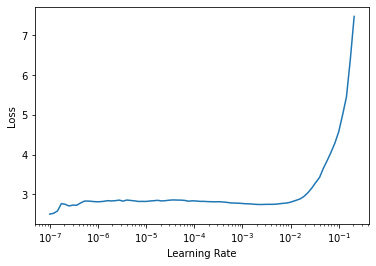

In [46]:
learn.lr_find()

In [45]:
learn.fit_one_cycle(1, 2e-3)


epoch,train_loss,valid_loss,perplexity,time
0,3.422462,3.825102,45.837479,00:06


In [57]:
prompt = "I need help with my computer system. I do not know"

In [58]:
prompt_ids = tokenizer.encode(prompt)
inp = tensor(prompt_ids)[None].cuda()
inp.shape

torch.Size([1, 12])

In [59]:
preds = learn.model.generate(inp, max_length=40, num_beams=5, temperature=1.5)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [60]:
tokenizer.decode(preds[0].cpu().numpy())

'I need help with my computer system. I do not know what to do.                        '